# Import Package

In [3]:
! pip install pyvirtualdisplay

In [5]:
! pip install tf_agents

     |████████████████████████████████| 1.2 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 7.2 MB/s  eta 0:00:01


In [43]:
import pyvirtualdisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.utils import common
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
import PIL.Image
from tf_agents.policies import random_tf_policy

In [44]:
tf.compat.v1.enable_v2_behavior()
# Set up a virtual display for rendering OpenAI gym environments.
#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Hyperparameters

In [46]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

# Environment

In [47]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

In [48]:
# Train and Evaluation(Testing)
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# Python to TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Agent / Algorithm

Y(s,a,r,s′)=r+γmaxa′Qθ−(s′,a′)

L(θ)=𝔼(s,a,r,s′)∼U(D)[(Y(s,a,r,s′)−Qθ(s,a))2]

## Create a QNetwork
Feed Forward network

In [49]:
fc_layer_params = (100,) # initial_collect_steps? input layer?

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    # A list of fully_connected parameters, 
    # where each item is the number of units in the layer
    fc_layer_params=fc_layer_params) 
#q_net

## Instantiate a DqnAgent 

Implements the DQN algorithm from

"Human level control through deep reinforcement learning" Mnih et al., 2015

https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf

In [50]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) # Adam algorithm

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer, # AdamOptimizer function
    td_errors_loss_fn=common.element_wise_squared_loss, # loss function
    train_step_counter=train_step_counter) # integer step counter

agent.initialize()


## Policies/Rules

The rules will return an action to produce the desired rewards

In [51]:
eval_policy = agent.policy # The main policy that is used for evaluation and deployment.
collect_policy = agent.collect_policy # A second policy that is used for data collection.

# Evaluation
Computes the average return of a policy per episode.

In [52]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Show baseline performance by randomly selection.

In [53]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
compute_avg_return(eval_env, random_policy, num_eval_episodes)

21.9

# Data Collection

## Replay Buffer
Dictionary?

In [54]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    # The maximum number of items that can be stored in a 
    # single batch segment of the buffer
    max_length=replay_buffer_max_length) 

agent.collect_data_spec, agent.collect_data_spec._fields

(Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))),
 ('step_type',
  'observation',
  'action',
  'policy_info',
  'next_step_type',
  'reward',
  'discount'))

Recording the data in the replay buffer.

In [55]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)


Covert the dictionary as a data set and return an iterator.

In [56]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
#dataset
iterator = iter(dataset)

# Train

Two things must happen during the training loop:

collect data from the environment

use that data to train the agent's neural network(s)

In [57]:
try:
  %%time
except:
  pass
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = []
losses = []

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  #if step % eval_interval == 0:
  avg_return = compute_avg_return(eval_env, agent.policy, 1)
    #print('step = {0}: Average Return = {1}'.format(step, avg_return))
  returns.append(avg_return)
  losses.append(train_loss)

step = 200: loss = 18.398178100585938
step = 400: loss = 14.568204879760742
step = 600: loss = 3.974918842315674
step = 800: loss = 7.82936954498291
step = 1000: loss = 2.6454858779907227
step = 1200: loss = 6.08250617980957
step = 1400: loss = 16.339977264404297
step = 1600: loss = 5.506181716918945
step = 1800: loss = 39.102577209472656
step = 2000: loss = 28.136919021606445
step = 2200: loss = 44.216697692871094
step = 2400: loss = 24.06719207763672
step = 2600: loss = 10.0909423828125
step = 2800: loss = 39.80750274658203
step = 3000: loss = 18.409879684448242
step = 3200: loss = 21.06759262084961
step = 3400: loss = 25.642637252807617
step = 3600: loss = 70.43470764160156
step = 3800: loss = 12.162662506103516
step = 4000: loss = 7.119634628295898
step = 4200: loss = 14.154354095458984
step = 4400: loss = 49.889259338378906
step = 4600: loss = 29.47924041748047
step = 4800: loss = 30.541362762451172
step = 5000: loss = 90.28516387939453
step = 5200: loss = 63.75636291503906
step =

KeyboardInterrupt: 

In [64]:
len(returns)
import numpy as np
np.array(returns)/2

array([  5. ,   4.5,   5. , ..., 100. ,  99.5,  90.5], dtype=float32)

# Visualization

Text(0.5, 0, 'Iterations')

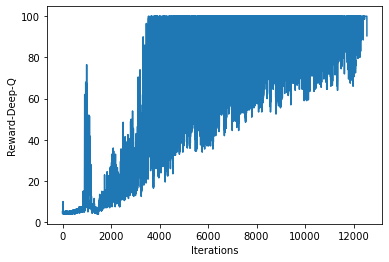

In [65]:
iterations = range(0, 12550)
plt.plot(iterations, np.array(returns)/2)
plt.ylabel('Reward-Deep-Q')
plt.xlabel('Iterations')
#plt.ylim(top=250)



In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, losses)
plt.ylabel('Loss-Deep-Q')
plt.xlabel('Iterations')
plt.ylim(top=250)


In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Reward-Deep-Q-Memory')
plt.xlabel('Iterations')
plt.ylim(top=250)


In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, losses)
plt.ylabel('Loss-Deep-Q-Memory')
plt.xlabel('Iterations')
plt.ylim(top=250)


# Reference
https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial